# Projet 6 : Classifiez automatiquement des biens de consommation

Dans ce projet, il est demandé d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories.

Dans cette partie, nous avons utilisé une méthodologie dite de "Transfert Learning" pour la classification de notre jeu de données de 1050 images. La méthodologie consiste a utiliser un  réseau de neurones pré-entrainé, l'adapter à notre problème de classification, et entrainer la dernière couche du réseau à partir de notre jeu d'entrainement.

Le modèle séléctionné est le ResNet et les poids se trouvent à l'adresse suivante :  https://www.google.com/search?q=resnet50_weights_tf_dim_ordering_tf_kernels_notop&oq=resnet50_weights_tf_dim_ordering_tf_kernels_notop&aqs=chrome..69i57j0l2.677j0j7&sourceid=chrome&ie=UTF-8  






####  Méthodologie :

- Utiliser un réseau de neurones pré-entrainé
- Adapter l'architecture du réseau au problème souhaité



Le jeu de données peut se télécharger à l'adresse suivante : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

#### Chargement des librairies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import cv2
import shutil
from PIL import Image
import matplotlib as mpl

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

# Librairies relatives au Transfert Learning
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras import Model, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow.python.keras import optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

#### Lecture des données

In [2]:
# Chemin d'accès aux données
path = "C:/OpenClassRoom/Projet_6/"
# Lecture des données
df = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")

In [3]:
# Chemin d'accès aux images
image_dir = 'C:\OpenClassRoom\Projet_6\Images'
img_paths = [join(image_dir, filename) for filename in df["image"].values]

#### Détermination des catégories pour chaque image

In [4]:
# On récupère la colomne "product_category_tree"
categories_1, categories_2 = [], []
for txt in df["product_category_tree"] :
    
    categories_1.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie
    categories_2.append(txt.split(">>")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
df["categories_1"] = pd.Series(categories_1)
df["categories_2"] = pd.Series(categories_2)

print("Il y a {} catégories dans la pronfondeur 1 et {} categories pour la profondeur 2".format(df["categories_1"].nunique(), df["categories_2"].nunique()))

Il y a 7 catégories dans la pronfondeur 1 et 63 categories pour la profondeur 2


In [5]:
def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

In [6]:
#X = np.array([cv2.resize(cv2.imread(image), (224, 224)) for image in img_paths])
X = np.array([image for image in img_paths])

y = df["categories_1"]

In [7]:
df["categories_1"].value_counts()

Baby Care                     150
Kitchen & Dining              150
Watches                       150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Beauty and Personal Care      150
Name: categories_1, dtype: int64

#### Séparation du jeu de données en Train et Test

In [8]:
# On découpe le jeu de donnée en jeu d'entrainement/test en respectant la proportion pour chaque classe
x_train, x_test, y_train, y_test, name_images_train, name_images_test = train_test_split(X,
                                                                                         y,
                                                                                         df["image"],
                                                                                         train_size=0.8,
                                                                                         stratify=y,
                                                                                         random_state=42)

#### Paramètres du réseau

In [14]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = df["categories_1"].nunique()

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 3
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

#### Création du réseau de neurones

In [17]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top=False, pooling=RESNET50_POOLING_AVERAGE))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
#model.add(MaxPooling1D(pool_size=4))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
# Labelisation des catégories de profondeur 1
categories_encoded = LabelEncoder().fit_transform(df["categories_1"])

#### Optimiseur Adam

In [19]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=OBJECTIVE_FUNCTION,
              optimizer=optimizer,
              metrics=LOSS_METRICS)

#### Préparation des mini batch pour l'entrainement et le test

In [9]:
# Répertoire des images d'entrainement
image_dir_train = 'C:/OpenClassRoom/Projet_6/images_train'
# Répertoire des images test
image_dir_test = 'C:/OpenClassRoom/Projet_6/images_test'

In [10]:
y_test

647                     Baby Care
342      Beauty and Personal Care
895               Home Furnishing
56       Beauty and Personal Care
386      Beauty and Personal Care
                  ...            
102    Home Decor & Festive Needs
120               Home Furnishing
672                     Baby Care
809      Beauty and Personal Care
783                     Baby Care
Name: categories_1, Length: 210, dtype: object

In [11]:
image_resize = 224
# Jeu d'entrainement

for x_, y_, name_image in zip(x_train, y_train, name_images_train) :
    new_dir = image_dir_train + "/" + y_
    if not os.path.exists(new_dir):
         os.makedirs(new_dir)
    image_resized = cv2.resize(cv2.imread(x_), (image_resize, image_resize)) # Resize de l'image
    image_recoded = Image.fromarray(image_resized) # Converti un array en image
    image_recoded.save(os.path.join(new_dir, name_image)) # Sauvegarde de l'image resizé


# Jeu Test
test_features, test_labels = [], []
for x_, y_, name_image in zip(x_test, y_test, name_images_test) :
    new_dir = image_dir_test + "/" + y_
    if not os.path.exists(new_dir):
         os.makedirs(new_dir)
    image_resized = cv2.resize(cv2.imread(x_), (image_resize, image_resize)) # Resize de l'image
    test_features.append(image_resized)
    test_labels.append(y_)
    image_recoded = Image.fromarray(image_resized) # Converti un array en image
    image_recoded.save(os.path.join(new_dir, name_image)) # Sauvegarde de l'image resizé

In [15]:
image_size = image_resize

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        image_dir_train,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        image_dir_test,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 840 images belonging to 7 classes.
Found 210 images belonging to 7 classes.


#### Entrainement du modèle

In [16]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=1050 // 30,  # added in Kaggle
                              epochs=NUM_EPOCHS,
                              validation_data=validation_generator,
                              validation_steps=10  # added in Kaggle
                             )

Epoch 1/3
35/35 [==============================] - 5115s 146s/step - loss: 0.9149 - accuracy: 0.6801 - val_loss: 0.8118 - val_accuracy: 0.7288
Epoch 2/3
35/35 [==============================] - 5512s 157s/step - loss: 0.3158 - accuracy: 0.9061 - val_loss: 0.7642 - val_accuracy: 0.7685
Epoch 3/3
35/35 [==============================] - 4770s 136s/step - loss: 0.1947 - accuracy: 0.9635 - val_loss: 0.8664 - val_accuracy: 0.7808


#### Sauvegarde du modèle

In [17]:
from tensorflow.keras.models import model_from_yaml
def saveModel(model, savename):
  # serialize model to YAML
  model_yaml = model.to_yaml()
  with open(savename+".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    print("Yaml Model ",savename,".yaml saved to disk")
  # serialize weights to HDF5
  model.save_weights(savename+".h5")
  print("Weights ",savename,".h5 saved to disk")

saveModel(model, "0310")

Yaml Model  0310 .yaml saved to disk
Weights  0310 .h5 saved to disk


In [20]:
model.load_weights("0310.h5")

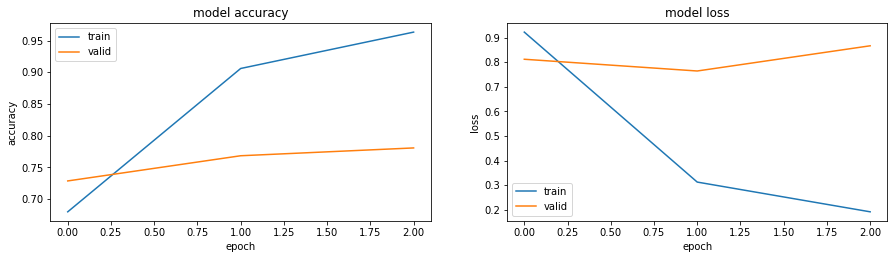

In [21]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [35]:
np.array(test_features).shape

(210, 224, 224, 3)

In [36]:
fnames = validation_generator.filenames
 
ground_truth = validation_generator.classes
 
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model.predict_classes(np.array(test_features), batch_size=210)
prob = model.predict(validation_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64

In [68]:
encoder = LabelEncoder()
encoder.fit_transform(y_train)

y_encoded = encoder.transform(y_test)

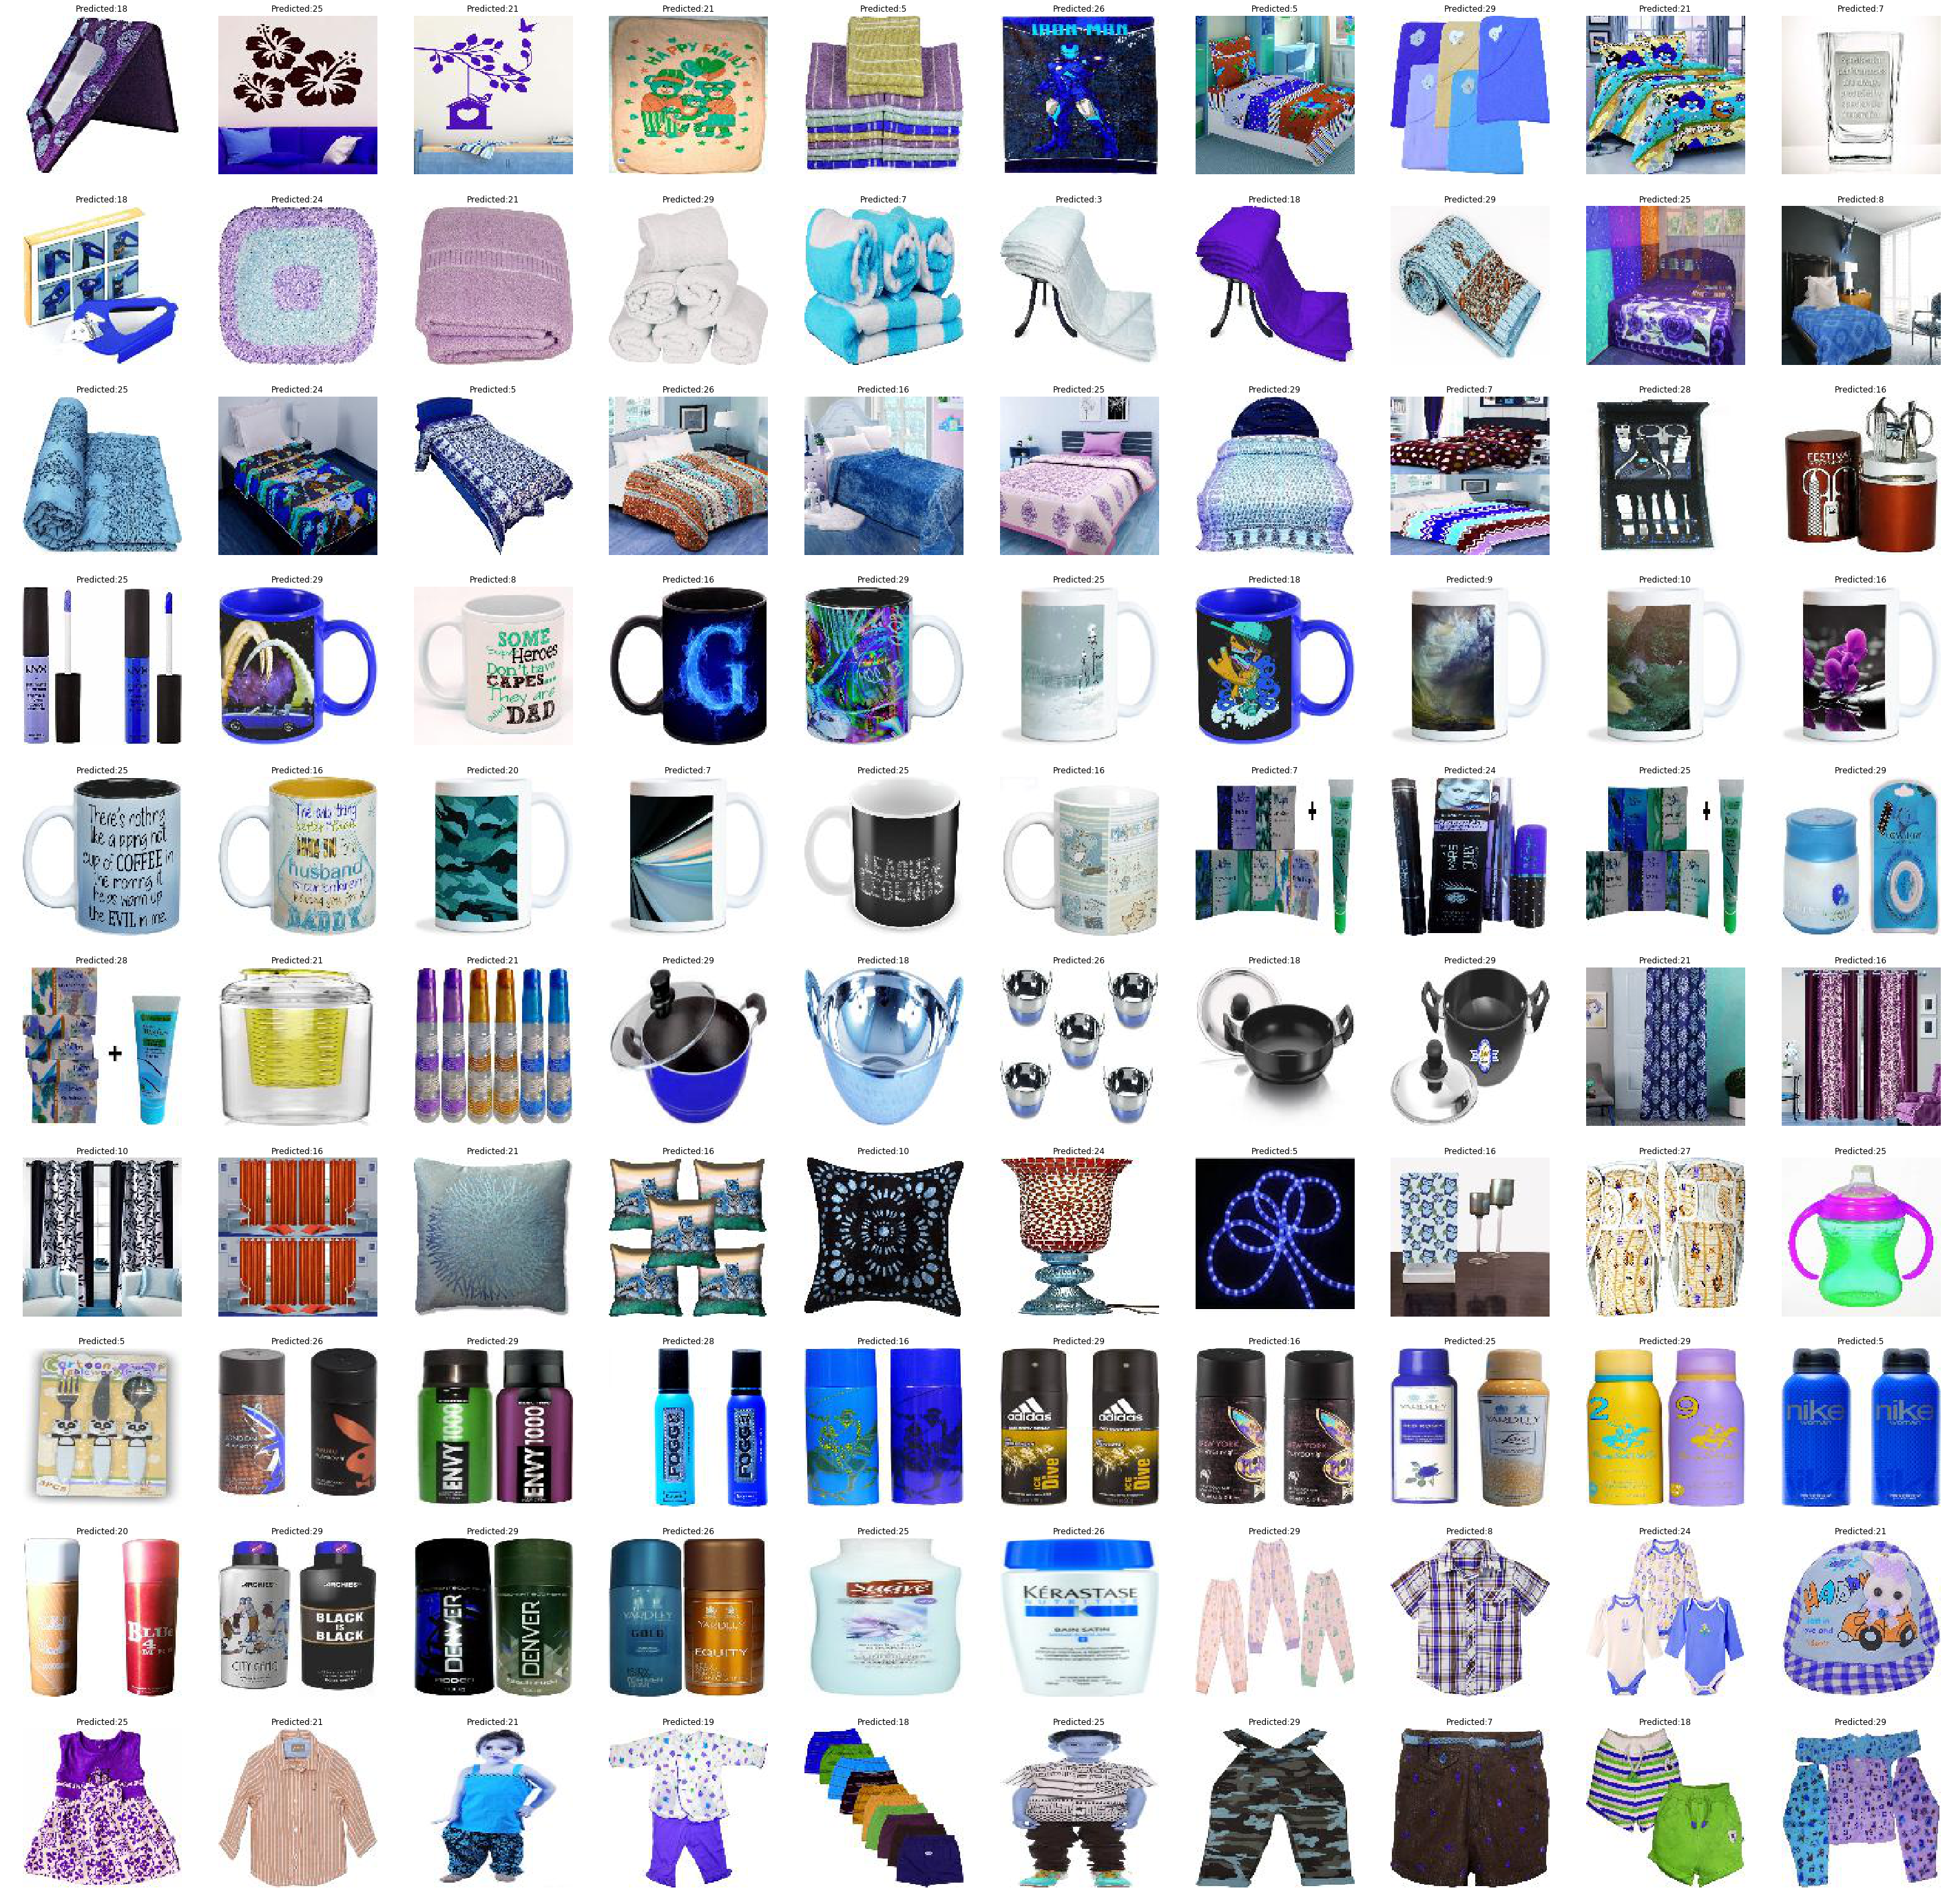

In [27]:
f, ax = plt.subplots(10, 10, figsize = (50, 50))

for i in range(0,100):
    imgBGR = cv2.imread(os.path.join(image_dir_test, validation_generator.filenames[i]))
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = predicted_class_indices[i]

    ax[i//10, i%10].imshow(imgRGB)
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [34]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(validation_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })

In [40]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(validation_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df["id"].apply(lambda x : x.split('/')[0])
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace=True)

results_df.to_csv('submission.csv', index=False)
results_df

id  label
0   NaN     18
1   NaN     25
2   NaN     21
3   NaN     21
4   NaN      5
5   NaN     26
6   NaN      5
7   NaN     29
8   NaN     21
9   NaN      7
10  NaN     18
11  NaN     24
12  NaN     21
13  NaN     29
14  NaN      7
15  NaN      3
16  NaN     18
17  NaN     29
18  NaN     25
19  NaN      8
20  NaN     25
21  NaN     24
22  NaN      5
23  NaN     26
24  NaN     16
25  NaN     25
26  NaN     29
27  NaN      7
28  NaN     28
29  NaN     16
..   ..    ...
180 NaN     25
181 NaN     29
182 NaN      5
183 NaN     25
184 NaN      7
185 NaN     29
186 NaN     29
187 NaN     18
188 NaN      5
189 NaN     25
190 NaN     29
191 NaN      7
192 NaN     18
193 NaN     29
194 NaN     10
195 NaN     18
196 NaN     25
197 NaN      8
198 NaN     25
199 NaN     28
200 NaN     25
201 NaN     29
202 NaN     23
203 NaN      8
204 NaN     24
205 NaN     11
206 NaN      5
207 NaN     25
208 NaN     26
209 NaN     11

[210 rows x 2 columns]